# Decouple Analysis from running GPX files #
## Intro ##
### Code Set Up ###

In [54]:
#imports
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as et
import numpy as np
import math
from datetime import datetime as dt
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
print("Setup Complete")

Setup Complete


### Definitions ###
We will be attempting to confirm whether or not the uploaded activity is performed primarily at the aerobic threshold using a metric known as 'heart-rate drift'. Heart-rate drift is measured by the variability of heart rate at a specific pace. Someone sufficiently fit exercising at their aerobic heart rate for an hour should be able to maintain their pace with their heart rate only increasing between 3% and 5%. If heart rate increases more than 5%, the effort was too hard. If heart rate increases less than 3% the effort was too easy. We will also be doing some visualization with Heart Rate, Pace, and Elevation gain.

### Assumptions ###
The run must be performed on a course that is either very flat, or has near identical elevation profiles in the two sections being analyzed.
<br>
The run must be performed sufficiently hydrated. Dehydration can cause the blood to become more viscous, thus making a higher heart rate necessary to pump blood through the body.
<br>
The run must be attempted at a constant pace.
<br>
The run must be a minimum of 50 minutes (more is better).

## Solution ##
### Data Structure ###
The activity is recorded in a 'GPX' format. This is an xml document with latitude, longitude, time, and other accessory variables such as heart rate or cadence. Lets view the first entry into the .gpx file.

In [2]:
#Long Easy Run data file
run_data_file = "activity_5758749241.gpx"
#Interval Run data file
#run_data_file = "activity_5737705799.gpx"
run_tree = et.parse(run_data_file)
run_root = run_tree.getroot()

# format is run_root[1][2][x][y] (opt: [0,z])
#x = measurement (every few seconds)
#y = (0 , elevation), (1, time), (2, extra stats)
#z = (0, hr), (1, cadence)
print("latitude: " + run_root[1][2][0].attrib['lat'])
print("longitude: " +run_root[1][2][0].attrib['lon'])
print("elevation: " + run_root[1][2][0][0].text)
print("time: " + run_root[1][2][0][1].text)
print("heart rate: " + run_root[1][2][0][2][0][0].text)
print("cadence: " + run_root[1][2][0][2][0][1].text)

latitude: 35.2427557669579982757568359375
longitude: -81.03792320005595684051513671875
elevation: 217
time: 2020-11-01T13:48:31.000Z
heart rate: 86
cadence: 0


I think it would be easiest to work with this data in a pandas dataframe, so I am going to create a dataframe with the full workout in it.

In [5]:
points_big_list = []
for points in run_root[1][2]:
    lat = points.attrib['lat']
    lon = points.attrib['lon']
    ele = float(points[0].text)
    time = pd.to_datetime(points[1].text, format = '%Y-%m-%dT%H:%M:%S.%fZ')#.strftime('%H:%M:%S')
    hr = int(points[2][0][0].text)
    cad = int(points[2][0][1].text)
    point_list = [time,lat,lon,ele,hr,cad]
    points_big_list.append(point_list)

In [6]:
df1 = pd.DataFrame(points_big_list,columns=['Time','Latitude','Longitude','Elevation','Heart Rate','Cadence'])
df1.set_index('Time',drop=False,inplace=True)
df1.head()

,Time,Latitude,Longitude,Elevation,Heart Rate,Cadence
Time,,,,,,
2020-11-01 13:48:31,2020-11-01 13:48:31,35.2427557669579982757568359375,-81.03792320005595684051513671875,217.000000,86,0
2020-11-01 13:48:32,2020-11-01 13:48:32,35.24275618605315685272216796875,-81.03792320005595684051513671875,217.000000,86,0
2020-11-01 13:48:37,2020-11-01 13:48:37,35.2428436093032360076904296875,-81.03791582398116588592529296875,217.399994,85,87
2020-11-01 13:48:41,2020-11-01 13:48:41,35.243051983416080474853515625,-81.03789704851806163787841796875,217.600006,85,82
2020-11-01 13:48:43,2020-11-01 13:48:43,35.24313739500939846038818359375,-81.0378778539597988128662109375,217.800003,87,83


### Distance Conversion ###
So, now we have a dataframe with all of the run data included. However, Latitude and Longitude are not particularly useful for us. What we want is distance. The formula for distance is given as:

$$ a = sin^2(\Delta \phi /2) + cos\phi_1 * cos\phi_2 * sin^2(\Delta\lambda/2) $$
$$ c = 2*atan2(\sqrt{a},\sqrt{1-a}) $$
$$ d = R * c $$
Where $\phi$ is latitude, $\lambda$ is longitude, R is earths radius (20,902,230.971129 feet)

In [7]:
def coord_dist(lat_1,lat_2,lon_1,lon_2):
    #returns distance in feet traveled from two points (lat_1,lon_1) to (lat_2,lon_2)
    lat_1 = math.radians(float(lat_1))
    lat_2 = math.radians(float(lat_2))
    lon_1 = math.radians(float(lon_1))
    lon_2 = math.radians(float(lon_2))
    a = math.sin((lat_2 - lat_1)/2)**2 + math.cos(lat_1)*math.cos(lat_2)*math.sin((lon_2-lon_1)/2)**2
    c = 2*math.atan2(a**.5,(1-a)**.5)
    R = 20902230.971129
    #print(R*c)
    return R*c

def speed(run_df):
    #Returns dataframe with Delta Time (in seconds) and Distance (in feet) from previous row. Requires dataframe with Longitude, Latitude, Time columns
    speed_df = run_df
    loc = speed_df[['Latitude','Longitude']]
    b = np.roll(loc,-1,axis=0)[:-1]
    a = loc[:-1]
    ba = zip(b[:,0],a['Latitude'],b[:,1],a['Longitude'])
    #print(list(ba))
    second = pd.Timedelta(seconds=1)
    dist = [0]
    for location in ba:
        dist_delta = coord_dist(location[0],location[1],location[2],location[3])
        dist.append(dist_delta)
    speed_df['Distance'] = dist
    delta_t_df = (np.roll(speed_df['Time'], -1) -speed_df['Time'])[:-1]
    delta_t = [0]
    delta_t[1:] = delta_t_df/second
    speed_df['Delta Time'] = delta_t
    #speed_df['Speed'] = speed_df['Distance']/(speed_df['Delta Time'])
    speed_df['Pace'] = (speed_df['Delta Time']*5280)/(speed_df['Distance'] * 60)
    return speed_df

In [11]:
speed_df = speed(df1)
speed_df.head()

,Time,Latitude,Longitude,Elevation,Heart Rate,Cadence,Distance,Delta Time,Pace
Time,,,,,,,,,
2020-11-01 13:48:31,2020-11-01 13:48:31,35.2427557669579982757568359375,-81.03792320005595684051513671875,217.000000,86,0,0.000000,0.0,NaN
2020-11-01 13:48:32,2020-11-01 13:48:32,35.24275618605315685272216796875,-81.03792320005595684051513671875,217.000000,86,0,0.152891,1.0,575.572478
2020-11-01 13:48:37,2020-11-01 13:48:37,35.2428436093032360076904296875,-81.03791582398116588592529296875,217.399994,85,87,31.968746,5.0,13.763443
2020-11-01 13:48:41,2020-11-01 13:48:41,35.243051983416080474853515625,-81.03789704851806163787841796875,217.600006,85,82,76.223089,4.0,4.618023
2020-11-01 13:48:43,2020-11-01 13:48:43,35.24313739500939846038818359375,-81.0378778539597988128662109375,217.800003,87,83,31.679719,2.0,5.555605


Now that we have our dataframe set up with all the values we will need, it is time to begin our analysis.

## Analysis ##
### Total Distance, Average Speed, and Average HR ###
For the first part of our analysis, we are interested in obtaining total distance traveled and average speed across the dataset. This will allow us to easily check the accuracy of our equation, as we can check against the formula used at Garmin or Strava. Distance should be fairly easy, as we will sum up all the numbers in the distance column, and convert to miles. Time will be similarly simple, as we can just take the time delta of the first and last rows.

In [29]:
distance_total_ft = speed_df['Distance'].sum()
distance_total_mile = distance_total_ft/5280
time_total_min = speed_df['Time'][-1] - speed_df['Time'][0]
time_total_moving = speed_df['Delta Time'].sum()
pace_total = time_total_min.seconds/(distance_total_mile*60)
pace_moving = time_total_moving/(distance_total_mile*60)
print("Distance: " + str(distance_total_mile) + " Miles\n" + "Time: " + str(time_total_min) + " Minutes\n" + "Pace: " + str(pace_total) + " Min/Mile\n" + "Pace (Moving):" + str(pace_moving) + " Min/Mile") 


Distance: 9.0161014538693 Miles
Time: 0 days 01:35:19 Minutes
Pace: 10.571827208727903 Min/Mile
Pace (Moving):10.571827208727903 Min/Mile


This tracks with the Garmin Connect data fairly well. Garmin connect has: 1:33:56 for time (moving), 1:35:19 elapsed time, 9.01 miles, and 10:25 min/mile average pace. In an effort to get closer to Garmins numbers, lets drop every row with low entry for pace and cadence. We will also be adding a heart rate weighted column to the dataframe in preperation for our next task. We weight the heart rate because the .gpx file does not have uniform time delta on the entries. So if we just averaged the heart rates, we would not account for the varying times of each entry.

In [43]:
speed_df['hr_weighted'] = speed_df['Heart Rate'] * speed_df['Delta Time']
speed_df_clean = speed_df[(speed_df['Cadence']>40) & (speed_df['Pace'] < 25)]
speed_df_clean = speed_df_clean.copy()
distance_total_ft = speed_df['Distance'].sum()
distance_total_mile = distance_total_ft/5280
time_total_min =speed_df['Time'][-1] - speed_df['Time'][0]
time_total_moving = speed_df_clean['Delta Time'].sum()/60
pace_moving = time_total_min.seconds/(distance_total_mile*60)
print("Distance: " + str(distance_total_mile) + " Miles\n" + "Time: " + str(time_total_moving) + " Minutes\n" + "Pace: " + str(pace_moving) + " Min/Mile" )

Distance: 9.0161014538693 Miles
Time: 93.31666666666666 Minutes
Pace: 10.571827208727903 Min/Mile


Our data does not exactly match up with Garmin, but we are closer.
<br><br>
Next, I would like to add in average heart rate to the mix. 

In [45]:

hr_weighted = speed_df_clean['hr_weighted'].sum()
avg_hr = hr_weighted/speed_df_clean['Delta Time'].sum()
print("Average HR: " + str(avg_hr) + " Beats/Min")

Average HR: 158.55759957135203 Beats/Min


Great! This tracks similarly with Garmin too, with Garmin coming in at 159 BPM
<br><br>
Now, lets graph all of this! We will probably want a cumulative distance column for simplicity.

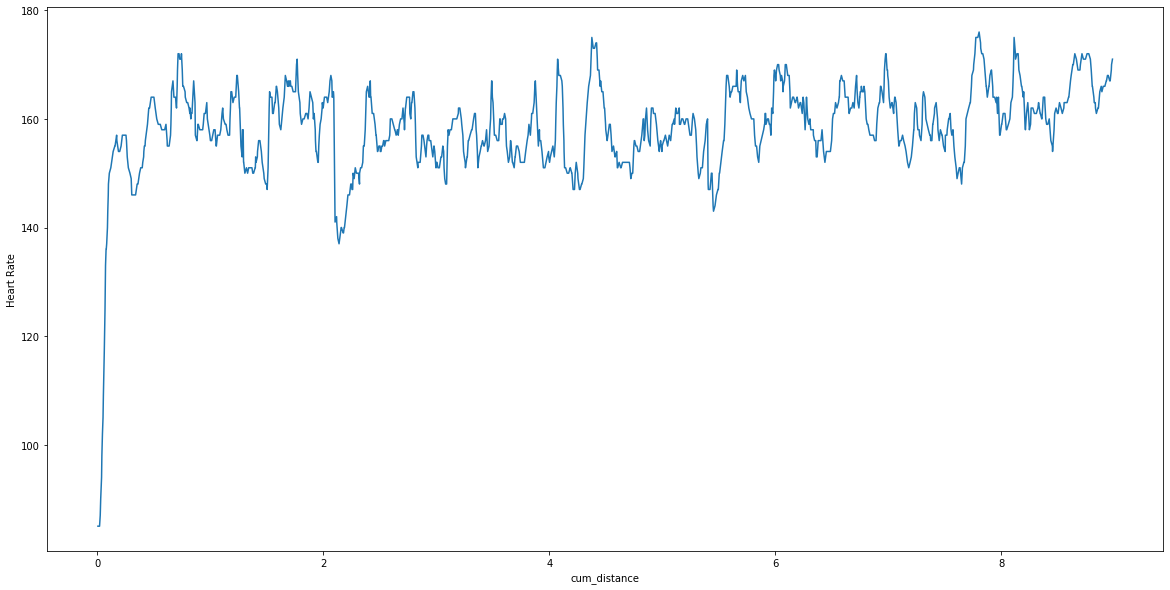

In [59]:
speed_df_clean['cum_distance'] = speed_df_clean['Distance'].cumsum()/5280
sns.lineplot(x='cum_distance', y='Heart Rate', data = speed_df_clean)

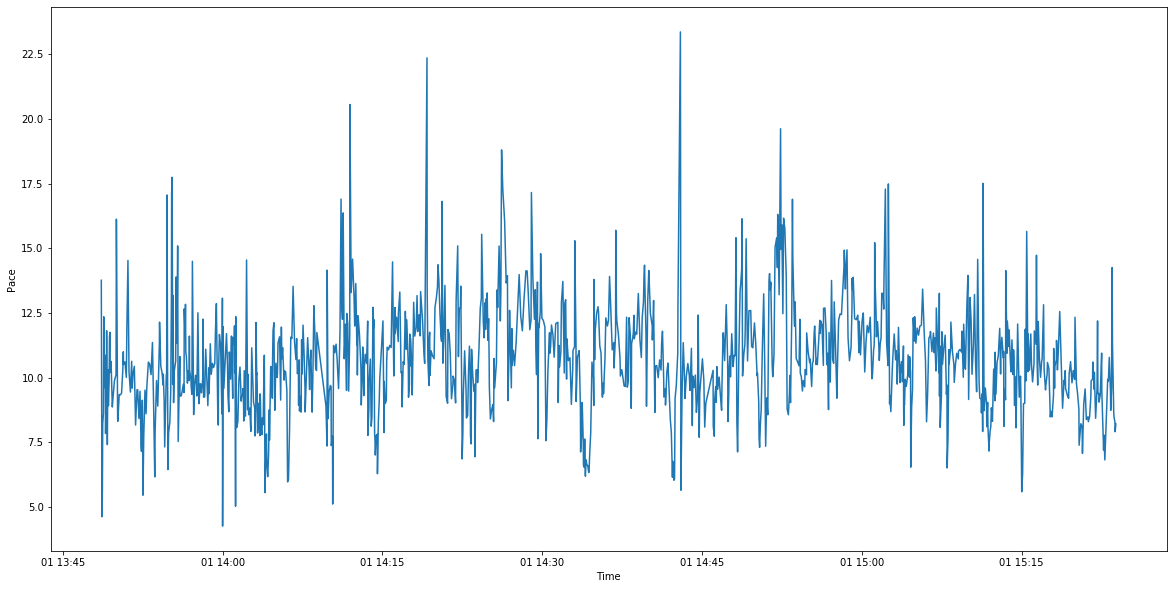

In [60]:
sns.lineplot(x='Time', y = 'Pace', data = speed_df_clean)

### Smoothing ###
That graph is really messy! Lets first try and resample.

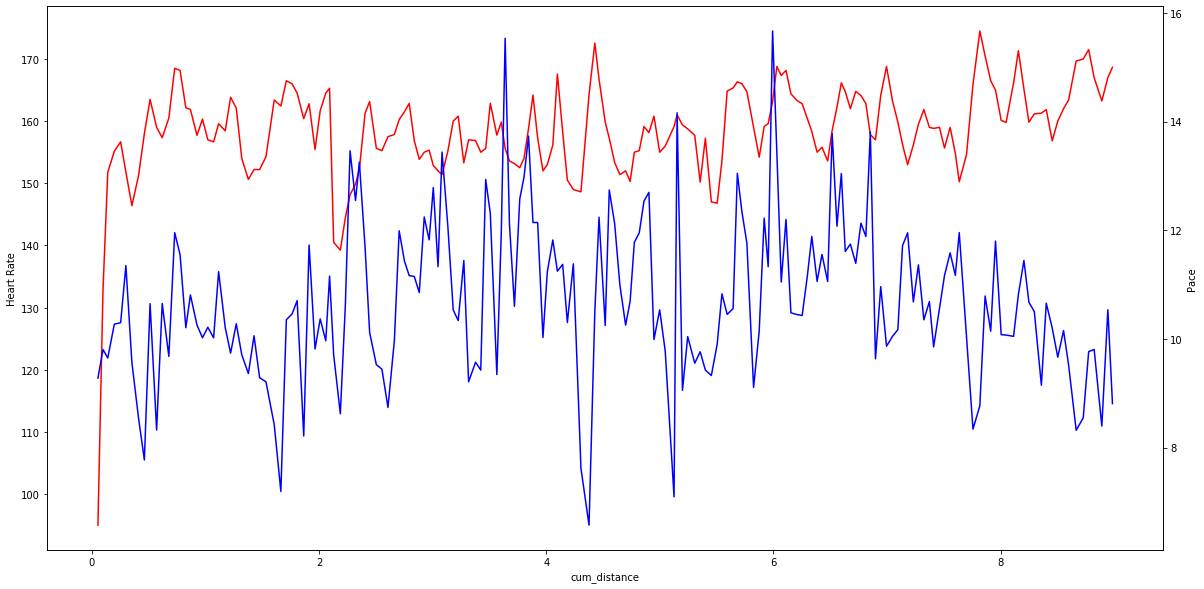

In [63]:
downsample_rate = '30s'
downsample_df = pd.DataFrame()
downsample_df['Pace'] = speed_df_clean.Pace.resample(downsample_rate).mean()
downsample_df['Heart Rate'] = speed_df_clean['Heart Rate'].resample(downsample_rate).mean()
downsample_df['cum_distance'] = speed_df_clean['cum_distance'].resample(downsample_rate).max()

min_dist = 0
max_dist = 9.2

sns.lineplot(x = 'cum_distance', y = 'Heart Rate', data = downsample_df[(downsample_df['cum_distance']>min_dist) & (downsample_df['cum_distance']<max_dist)], color = 'r')
ax2 = plt.twinx()
sns.lineplot(x='cum_distance', y = 'Pace', data = downsample_df[(downsample_df['cum_distance']>min_dist) & (downsample_df['cum_distance']<max_dist)], color = 'b', ax = ax2)

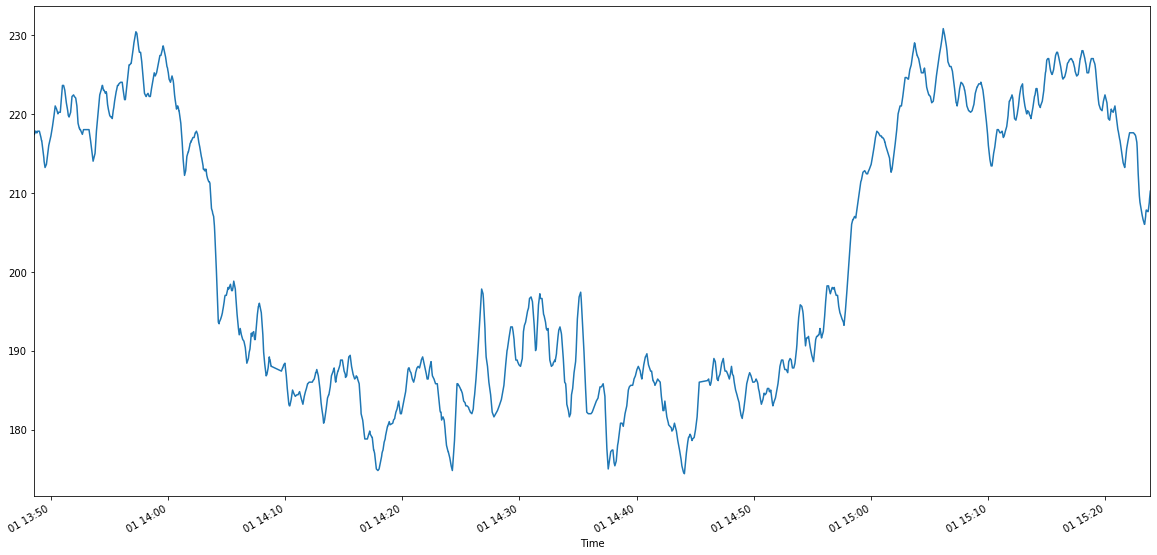

In [87]:
speed_df_clean['Elevation'].plot()

Great! So we see a few things. The graph is much easier to view when it is resampled! We also see that pace roughly tracks with HR. There are a few execptions to this, which I think would be best explained by Elevation change, as seen above. However, this graph is still not looking great. Lets try a rolling mean instead.

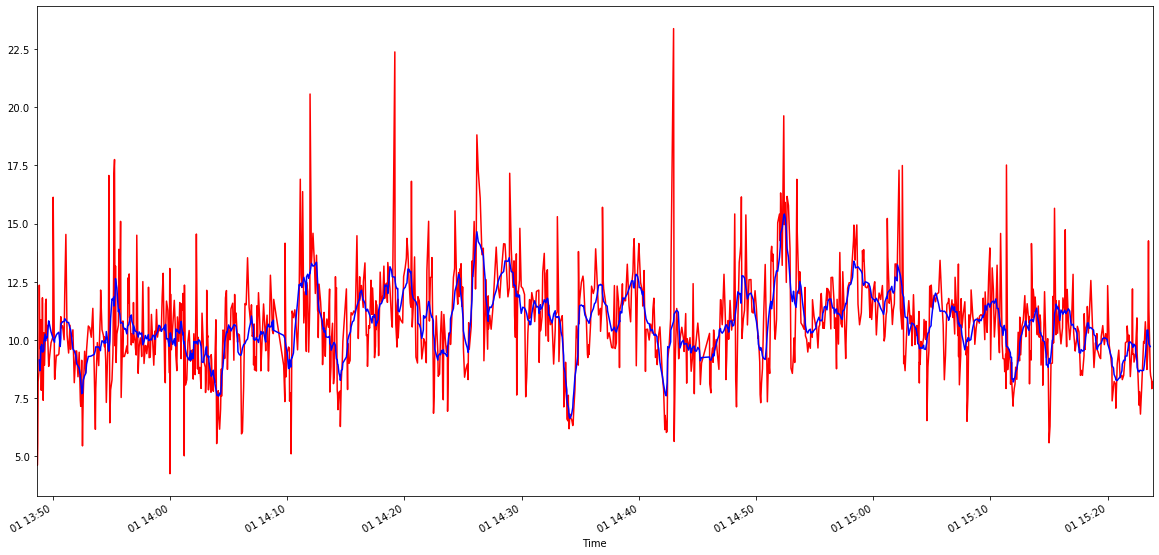

In [73]:
speed_df_clean['Pace'].plot(color='r')
speed_df_clean['Pace'].rolling(10, center=True).mean().plot(color='b')

That looks way better. Lets compare to the resample.

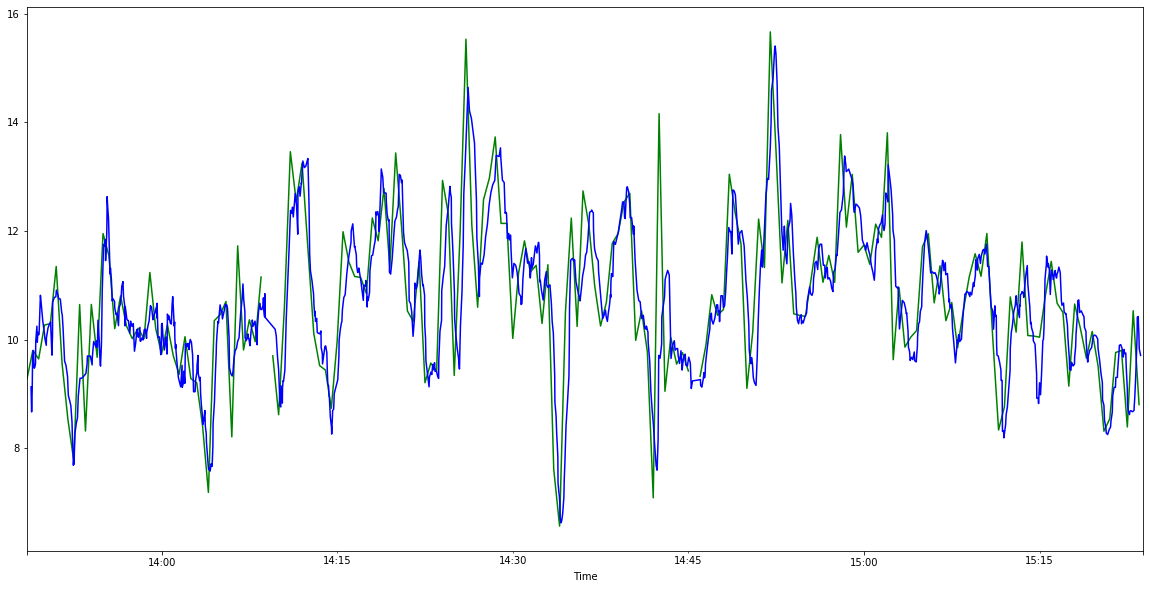

In [77]:
downsample_df['Pace'].plot(color='g')
speed_df_clean['Pace'].rolling(10, center=True).mean().plot(color='b')

I prefer the rolling window. Now lets see if we can improve it even further. We will try a Gaussian window.

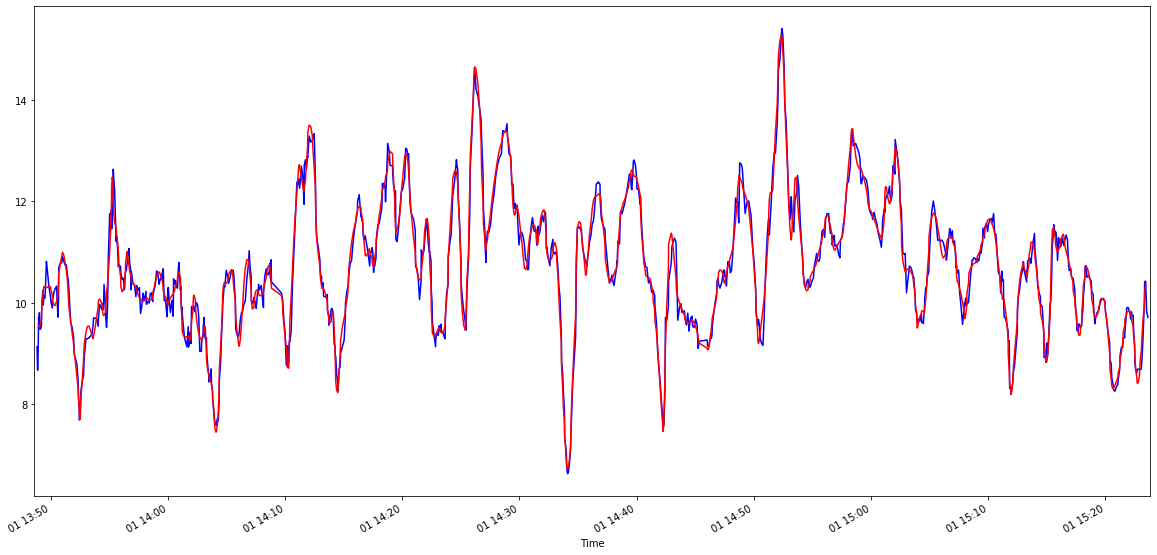

In [83]:
speed_df_clean['Pace'].rolling(10, center=True).mean().plot(color='b')
speed_df_clean['Pace'].rolling(15, center=True, win_type = 'gaussian').mean(std=3).plot(color='r')

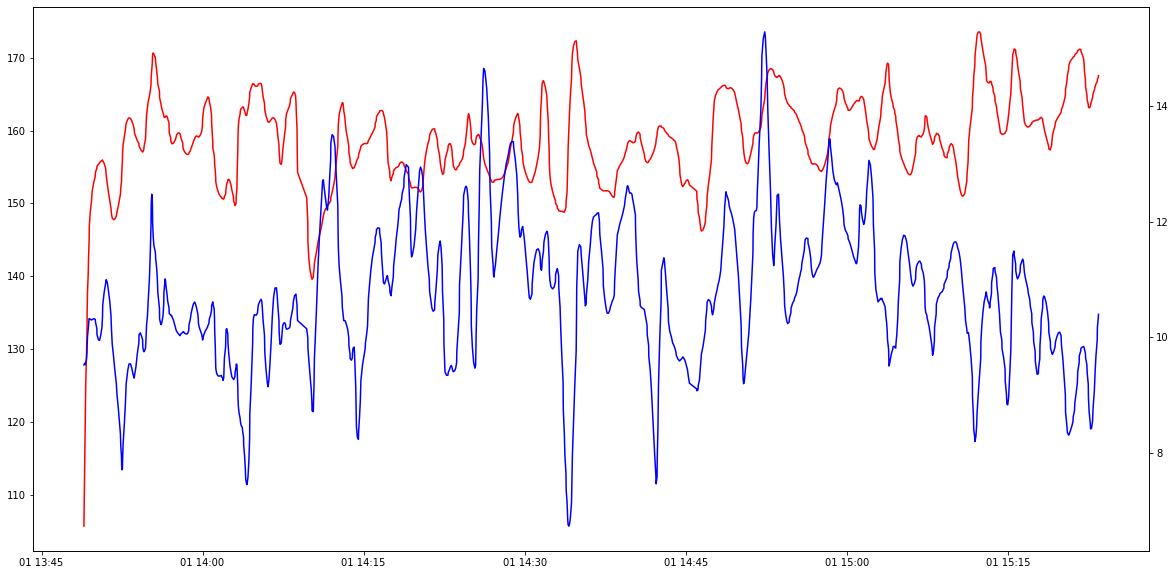

In [102]:
hr_rolling = speed_df_clean['Heart Rate'].rolling(15, center=True, win_type = 'gaussian').mean(std=3)

pace_rolling = speed_df_clean['Pace'].rolling(15, center=True, win_type = 'gaussian').mean(std=3)
ax1 = plt.subplot()
ax1.plot(hr_rolling, color='r')
ax2 = ax1.twinx()
ax2.plot(pace_rolling, color='b')

### Basic Decouple ###
Now, lets make a function to calculate decouple rate. The first method we will use is the method recommended by Training Peaks. We will split the sample in half, and calculate the pace/hr rate for half one, and the pace/hr rate for half two. If there is little variation in these values, then we are not decoupled (higher value means more decoupling). We would prefer a flatter course for this analysis. However, between miles 2 and 6 we should have roughly the same elevation gain and drop in each half. Because of this, we would expect our decoupling analysis to be fairly accurate for this section.

In [104]:
def decouple_rate(HR_Series, Pace_Series):
    #We receive a Heart Rate time series, and a Pace time series with the same index. 
    #Then we calculate decouple rate based on the halfway point.
    #More accurate for flatter courses.
    length = int(len(HR_Series)/2)
    hr1 = HR_Series[:length].mean()
    p1 = Pace_Series[:length].mean()
    hr2 = HR_Series[length:].mean()
    p2 = Pace_Series[length:].mean()
    print(hr1,p1,hr2,p2)
    return ((p1/hr1)-(p2/hr2))/((p1/hr1))
decouple_rate_sample = speed_df_clean[(speed_df_clean['cum_distance']>2) & (speed_df_clean['cum_distance']<6)]
decouple = decouple_rate(decouple_rate_sample['Heart Rate'], decouple_rate_sample['Pace'])
print("Decoupling Rate of: " + str(round(decouple*100,2)) + "% Decoupling. Between 3.5 and 5 is aerobic threshold.")
print("Average Pace of: " +  str(decouple_rate_sample['Pace'].mean()) + " Min/Mile")

156.08527131782947 11.207560605961952 157.63953488372093 10.750807730059611
Decoupling Rate of: 5.02% Decoupling. Between 3.5 and 5 is aerobic threshold.
Average Pace of: 10.979184168010775 Min/Mile


So we see that we have achieved 4.65% decoupling between miles 2 and 6 on the run. THis is about 40 minutes worth of activity. We did not use the begining and end of the run because of elevation change concerns. The average pace during this section was about 10:55 minutes per mile. This looks to be a little above my current aerobic threshold. Current Lactate Threshold is about 8-8:30 per mile, and 5K pace is 7:00 per mile.
<br> <br>
### Advanced Decouple (future) ###
Now lets try and calculate decouple rate by estimating pace based on HR and Elevation change. Once we can predict pace for the first half of the run, we will run the prediction for the second half of the run and compare expected vs actual results.